# Baruch IMG Portfolio Management Risk

In [1]:
# Data manipulation 
import numpy as np
import pandas as pd
import time as t

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Stock Pulling  
from alpha_vantage.timeseries import TimeSeries

# Google Sheet Authorization
import gspread
from oauth2client.service_account import ServiceAccountCredentials

For more information on the alpha_vantage api or the python wrapper feel free to read the documentation provided
- AV API Docs https://www.alphavantage.co/documentation/
- Python Wrapper by Romel https://github.com/RomelTorres/alpha_vantage

**NOTE that AV API limits call requests to 5 calls to server a minute - an adapter is built in to counter**

In [2]:
api_key = "JAFMAHL3Q9GKBXC1" #Alpha vantage api-key recieived throguh the service

## Risk Management Helper Functions 

In [3]:
# data columns present from timeseries pull by Alpha Vantage API
data_columns = ['1. open', '2. high', '3. low', '4. close', '5. adjusted close', 
                '6. volume', '7. dividend amount', '8. split coefficient']

In [4]:
def stock_puller(ticker_list: list, col: str, outputsize: str = 'compact', length = 252):
    """
    Extracts stock/security data from Alpha Vantage
    :param ticker_list: a list of tickers for data to be extracted eg: ['SPY', 'GOOG', 'AAPL']
    :param col: provided string to extract the desired column type, illustrated in column_desc list
    :param outputsize: 'compact' = 100 most recent, 'full' = historical security list
    :return: returns a dataframe object with relevant timeseries data (index by date, column ticker symbols)
    """
    big_dict = {}
    ts = TimeSeries(key=api_key, output_format='pandas', retries=10) # function call from Python wrapper to extract timeseries 
    
    for ticker in ticker_list:
        # iterates through the security list provided and extracts relevant timeseries information
        data = ts.get_daily_adjusted(symbol=ticker, outputsize=outputsize)[0][col]

        big_dict[ticker] = data[-length:].tolist()  # dictionary storing security time series for faster concatination 
        t.sleep(12)
        
    big_df = pd.DataFrame.from_dict(data=big_dict)  # returns large dataframe for list of securities
    return big_df

In [5]:
def log_returns(price_df: pd.DataFrame):
    """
    Extracts the log returns for relevant price data
    :param price_df: a dataframe object storing price values for a given underlying (index by date, column ticker symbols)
    :return: a dataframe for log returns of select securities
    """
    big_dict = {}

    for ticker in price_df.columns:
        # iterates through the security list provided and extract provided values via dict manipulation
        security_list = price_df[ticker]
        log = np.log(security_list.values) - np.log(np.roll(security_list.values, 1))  # computes log return 
        big_dict[ticker] = log[1:].tolist() # eliminates the first NaN row and returns list from ndarray

    big_df = pd.DataFrame.from_dict(data=big_dict) # dataframe index by data column all ticker symbols
    return big_df

In [6]:
def linear_returns(price_df: pd.DataFrame):
    """
    Extracts the linear returns for relevant price data 
    :param price_df: a dataframe object storing price values for a given underlying (index by date, column ticker symbols)
    :return: a dataframe for linear returns of select securities
    """
    big_dict = {}

    for ticker in price_df.columns:
        # iterates through the security list provided and extract provided values via dict manipulation
        linear_ret = price_df[ticker].pct_change() # pct_change pandas function for linear returns
        big_dict[ticker] = linear_ret[1:].tolist() # eliminates the first NaN row and returns list from ndarray 

    big_df = pd.DataFrame.from_dict(data=big_dict) # dataframe index by data column all ticker symbols
    return big_df

In [7]:
def volatility(price_df: pd.DataFrame, rolling_window: int = 10):
    """
    Extracts the rolling standard deviation of log returns for price data
    :param price_df: a dataframe object storing price values for a given underlying (index by date, column ticker symbols)
    :param rolling_window: the length to which rolling standard deviation is taken 
    :return: a dataframe for linear returns of select securities
    """
    log_ret = log_returns(price_df)
    
    big_dict = {}

    for ticker in price_df.columns:
        # iterates through the security list provided and extract provided values via dict manipulation
        volatility = log_ret[ticker].rolling(rolling_window).std() # rolling standard deviation pandas function for log returns
        big_dict[ticker] = volatility[rolling_window-1:].tolist() # eliminates the NaN rows and returns list from ndarray 

    big_df = pd.DataFrame.from_dict(data=big_dict) # dataframe index by data column all ticker symbols
    return big_df

In [8]:
def google_api():
    # use creds to create a client to interact with the Google Drive API
    scope = ['https://spreadsheets.google.com/feeds']
    creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)
    client = gspread.authorize(creds)


========================================================================================================================

========================================================================================================================

### Data Wrangling (Portfolio Selection)

In [9]:
# list of securities you would like to gather information on eg: ['AMZN', 'FB', 'GOOG']
portfolio_list = ['ALB','AMZN','AEP','AWK','BAX','BCE','BX','BP',
                  'CP','CIM','CHD','EFX','EL','HII','LMT','NATI',
                  'OFC','RIO','ROP','RY','STI','WM','WY']

In [10]:
# dataframe storing ticker timeseires, index by time, with tickers for columns
data = stock_puller(ticker_list=portfolio_list, col='5. adjusted close', outputsize='full', length=252*5)

In [11]:
data.head()

,ALB,AMZN,AEP,AWK,BAX,BCE,BX,BP,CP,CIM,...,HII,LMT,NATI,OFC,RIO,ROP,RY,STI,WM,WY
0,59.2495,358.32,41.7589,39.3850,34.7147,32.0183,22.9657,37.1314,148.9786,7.7366,...,90.9040,142.1352,25.8346,22.0375,43.3723,131.1460,51.8865,33.3191,35.7095,24.7675
1,60.4293,359.80,41.9340,39.3133,34.9928,31.8627,22.7844,36.9482,148.0809,7.7613,...,90.8103,139.7201,26.0213,21.7431,43.1282,130.8358,51.2694,33.4620,35.7883,24.8917
2,60.4477,360.13,41.5420,39.4478,34.8310,32.0628,22.9866,36.9408,147.7753,7.8108,...,94.3528,141.4055,25.7634,21.7677,44.0056,130.4772,51.4751,33.6680,35.5518,24.6082
3,60.8256,362.10,41.8756,40.1826,35.1394,32.3073,23.2586,37.0874,149.9336,7.8849,...,94.9619,142.1588,25.7634,21.8085,43.7156,131.4561,51.4514,33.7486,36.3578,24.6082
4,60.5952,359.78,41.4752,39.5643,34.8310,32.1814,22.7914,35.9076,149.1219,7.8602,...,96.7706,143.2536,25.4344,21.6205,42.5407,130.5547,51.3011,33.3276,36.1650,24.4164


In [12]:
exp_ret = pd.DataFrame(linear_returns(data).mean() * 252).transpose() # expected returns dataframe

In [13]:
exp_ret

,ALB,AMZN,AEP,AWK,BAX,BCE,BX,BP,CP,CIM,...,HII,LMT,NATI,OFC,RIO,ROP,RY,STI,WM,WY
0,0.13227,0.351161,0.145551,0.202931,0.171884,0.074685,0.112248,0.05507,0.099436,0.190283,...,0.2015,0.169059,0.147212,0.050179,0.113496,0.197221,0.095216,0.163513,0.215511,0.028902


In [14]:
cov = data.cov() # covariance matrix for calculations later

In [15]:
cov.head() 

,ALB,AMZN,AEP,AWK,BAX,BCE,BX,BP,CP,CIM,...,HII,LMT,NATI,OFC,RIO,ROP,RY,STI,WM,WY
ALB,643.570543,8228.636315,195.503181,333.594847,281.282496,81.927547,50.197095,69.084998,153.085580,79.380813,...,1159.062400,1292.861556,149.445912,79.267464,126.136591,983.170571,228.713671,249.399262,348.565878,59.780003
AMZN,8228.636315,239900.793426,4177.911156,7251.069975,6410.249201,1272.659881,1476.717590,1821.288371,5512.505964,1635.492484,...,23282.589204,27751.971495,3558.449126,864.588568,2889.793284,25098.298054,4334.595564,5650.203839,8163.818917,889.445263
AEP,195.503181,4177.911156,97.824656,161.214962,120.616962,32.349339,23.736754,24.091127,72.126040,34.423177,...,466.387445,552.243735,64.928300,23.345761,41.207366,466.584269,81.524915,99.594486,165.862258,16.069295
AWK,333.594847,7251.069975,161.214962,275.810171,204.888483,54.606239,37.024323,41.380100,102.690376,58.582414,...,810.433318,956.464741,107.121293,39.049595,67.566396,785.726272,138.526403,173.317518,282.690315,28.295850
BAX,281.282496,6410.249201,120.616962,204.888483,189.620656,40.878815,41.710657,55.538187,175.618004,47.569017,...,674.347495,791.295386,104.097003,32.295524,94.060214,702.318753,136.407939,161.732748,229.860780,30.524742


## Correlation Studies

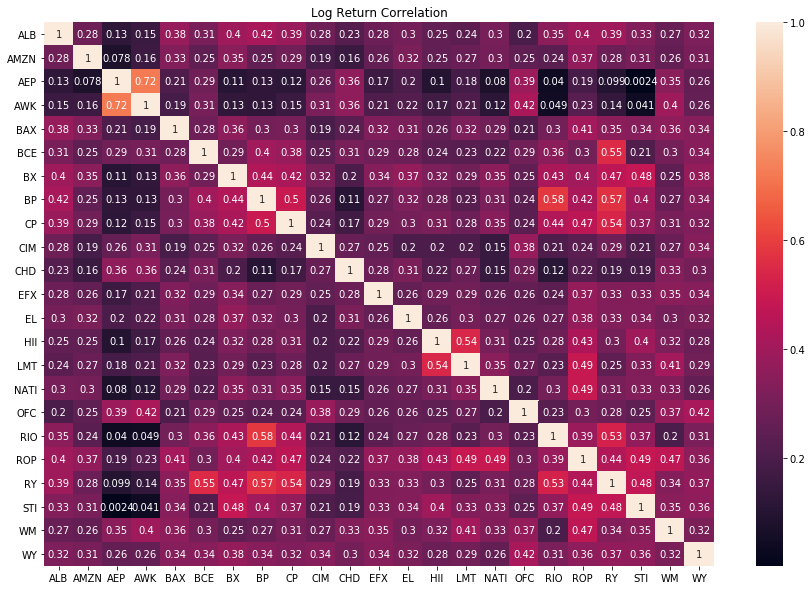

In [16]:
lr = log_returns(price_df=data).corr(method='pearson')
plt.figure(figsize=(15,10)) # adjusts the size of the plot for better viewin
plt.title('Log Return Correlation')
sns.heatmap(lr, annot=True) # plots heatmap 

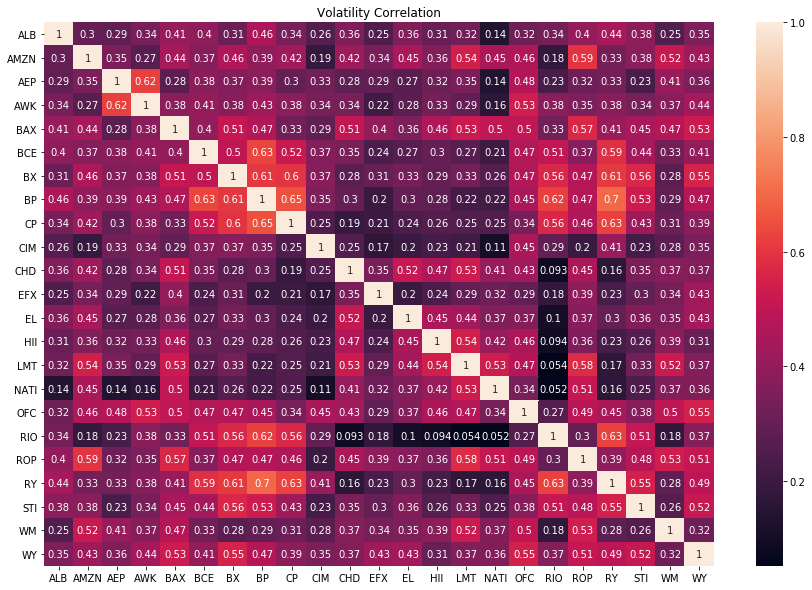

In [17]:
vol = volatility(price_df=data).corr(method='pearson')
plt.figure(figsize=(15,10)) # adjusts the size of the plot for better viewing 
plt.title('Volatility Correlation')
sns.heatmap(vol, annot=True) # plots heatmap 

## RIsk Management Models
Risk is quantifiable both in absolute and in relative terms. A solid understanding of risk in its different forms can help investors to better understand the opportunities, trade-offs, and costs involved with different investment approaches. Our goal here is to quantify systemic risk associated with the portfolio

In [18]:
# Value-at-Risk
def VaR():
    return 1

In [19]:
# Conditional Value-at-Risk
def CVaR():
    return 1

In [20]:
def Beta():
    return 1

## Portfolio Metrics 

In [3]:
def Sharpe():
    return 1

In [4]:
def Sortino():
    return 1

In [5]:
def Treynor():
    return 1

========================================================================================================================

========================================================================================================================

## Portfolio Optimization Models
The following scripts are used for optimizing a given portfolio in a purely quantitative scenario. Our goal is to construct models as to compare current portfolio weights, to help guide portfolio management and decisions regarding whether to sell positions believed to be theoretically overweight.

In [21]:
# Minimum variance portfolio (MVP)
def MVP(cov: np.matrix, mu: np.array):
    """
    Given target return, determine the weights of the portfolio with the smallest variance
    :param cov: provided covariance matrix for the underlying securities (np.matrix object)
    :param mu: expected returns/historical returns for underlying securities (np.array object)
    :return: a dict containing the weights of the provided portfolio
    """
    base = np.ones(len(mu[0]))
    inv = np.linalg.inv(cov.values)
    
    weights = (inv.dot(base)) / (base.dot(inv).dot(base))
    exp_return = (mu.dot(inv).dot(base)) / (base.dot(inv).dot(base))
    
    return weights, exp_return

In [22]:
# Market Portfolio Optimization (MPO)
def MPO(cov: np.matrix, mu: np.array, risk_free: float):
    """
    Given target return, determine the weights of the optimal market portfolio
    :param cov: provided covariance matrix for the underlying securities (np.matrix object)
    :param mu: expected returns/historical returns for underlying securities (np.array object)
    :param risk_free: current risk_free rate in 10 year bonds
    :return: a dict containing the weights of the provided portfolio
    """
    assert 0 < risk_free < 1

    base = np.ones(len(mu[0]))
    inv = np.linalg.inv(cov.values)
    
    weights = ((mu-risk_free*base).dot(inv)) / ((mu-risk_free*base).dot(inv).dot(base))
    
    return weights

In [34]:
MPO(cov, exp_ret.values, 0.0266)[0]

array([-3.55480483e-02, -3.55573292e-03, -4.64496065e-02,  4.83097494e-02,
        9.03748916e-02,  4.95293763e-02,  8.09208816e-02,  1.05955730e-01,
        9.79679154e-03,  1.08352355e+00, -1.26241954e-01, -6.70370187e-03,
        1.98622394e-02, -5.61523171e-04, -4.90584725e-04,  1.70424422e-01,
       -1.67072857e-01, -1.27883121e-01, -4.08800076e-02, -8.65890255e-02,
        5.71312131e-02, -6.28243202e-02, -1.10283576e-02])

In [26]:
wt, ret = MVP(cov, exp_ret.values)

In [33]:
wt

array([-4.75961008e-02, -1.38033453e-03, -1.74070101e-02, -7.24377891e-03,
       -1.36298388e-04,  1.69716549e-01,  7.54981220e-02,  1.92080556e-01,
       -1.82205003e-02,  6.43184636e-01, -2.90783974e-02, -2.30583034e-02,
        3.37470433e-03, -1.18111020e-02,  1.31737844e-02,  1.42409103e-01,
        2.28991179e-03, -1.22650585e-01, -2.60423390e-02, -1.75233387e-03,
        5.36320835e-03, -3.20511882e-02,  9.13376969e-02])